# Zillow - Data Cleaning

This file extracts relevant information from the Zillow 2 bedroom data file.

It saves the subset file to disk to be shared amongst other notebooks.

In [1]:
# These configurations expand the Jupyter notebook 
# They also control how much output can be displayed for each cell
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 30)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary python packages
from os import listdir
from os.path import join as pjoin
import pandas as pd
from time import time, sleep
import dateutil.parser

# Import necessary utilities
from Utils.DataUtils import *
from Utils.UtilsViz import *

---------------------------------------------------------------------------------------------------------------

In [4]:
# Have a quick look at the data folder
data_path = "./data"
listdir(data_path)

['listings.csv', 'listings.csv.gz', 'Zip_Zhvi_2bedroom.csv']

In [5]:
# Load the Zillow data file
data = pjoin(data_path, 'Zip_Zhvi_2bedroom.csv')
zillow_data = pd.read_csv(data)
display(
    zillow_data.shape,
    zillow_data.head())

(8946, 262)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,...,368600,370200,372300,375300.0,378700,381400,381800,382100,383300,385100
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
3,84616,60614,Chicago,IL,Chicago,Cook,4,195800.0,193500.0,192600.0,...,398900,401200,403200,405700.0,408300,408800,408000,410100,412200,412200
4,93144,79936,El Paso,TX,El Paso,El Paso,5,59100.0,60500.0,60900.0,...,82400,82300,82400,82300.0,82500,83200,83900,84100,83900,83700


In [6]:
print("Total number of cities :", len(zillow_data["City"].unique()))

Total number of cities : 4684


This file contains data from several cities.

Let's filter out the data just for New york City

In [7]:
q = "City==\"New York\""
zillow_nyc = zillow_data.query(q).reset_index(drop=True)
print("Number of rows for NYC :", zillow_nyc.shape[0])
display(
    zillow_nyc.head()
)

Number of rows for NYC : 25


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
2,61703,10128,New York,NY,New York,New York,14,NaN,NaN,NaN,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
3,61625,10011,New York,NY,New York,New York,15,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
4,61617,10003,New York,NY,New York,New York,21,NaN,NaN,NaN,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


In [8]:
# How many regions do we have?
print("Number of unique Zipcode data available :", zillow_nyc["RegionName"].unique().shape[0])

Number of unique Zipcode data available : 25


We have information on 25 Zip Codes

How many missing values are there?

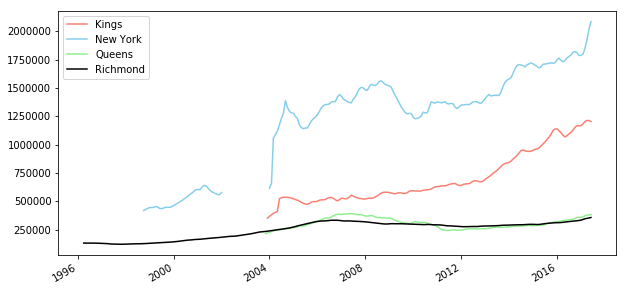

In [21]:
year_cols = [c for c in zillow_nyc.columns if c not in ["RegionID", "RegionName", "City", "State", "Metro", "CountyName", "SizeRank"]]
county_df = zillow_nyc[["CountyName"]+year_cols].groupby(by="CountyName", as_index=True).median()
county_df_t= county_df.transpose()
county_df_t.index = pd.to_datetime(county_df_t.index)

f, ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
color_map = {"Kings":"salmon", "New York":"skyblue", "Queens":"lightgreen", "Richmond":"black"}    
for c in county_df_t.columns:
    ax.plot_date(county_df_t.index, county_df_t[c], label=c, color=color_map[c], linestyle="-", fmt='-')
ax.legend()
plt.gcf().autofmt_xdate()
plt.show()


In [9]:
znyc_nans = analyse_nans(zillow_nyc).loc["percentage",:].to_frame().reset_index()
znyc_nan_grp = znyc_nans.groupby("percentage", as_index=False).count()
znyc_nan_grp.columns = ["percentage missing", "num_rows"]
znyc_nan_grp["percentage_rows"] = np.round(100*znyc_nan_grp["num_rows"] / znyc_nan_grp["num_rows"].sum(), 2)
znyc_nan_grp

,percentage missing,num_rows,percentage_rows
0,0.0,128,48.85
1,4.0,20,7.63
2,12.0,6,2.29
3,16.0,6,2.29
4,20.0,1,0.38
5,40.0,3,1.15
6,48.0,3,1.15
7,52.0,2,0.76
8,56.0,1,0.38
9,64.0,41,15.65


1. Zillow data not available for all years for all zip codes
1. Only 48.85% rows have no missing values

From what point can we start using the data without any imputation?

In [10]:
zipcode_colname = ["RegionName"]
region_info_cols = ["RegionID", "City", "State", "Metro", "CountyName", "SizeRank"] + zipcode_colname
year_cols = [c for c in zillow_nyc.columns if c not in region_info_cols]

One assumption we can make is that, since the AirBnB data is for 2019, we can take roughly 12 years of previous housing data in the zip codes, to observe trends.

In [11]:
filtered_year_cols = [c for c in year_cols if int(c[:4]) >= 2007][5:]
analyse_nans(zillow_nyc[filtered_year_cols]).iloc[:2,:]

,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
percentage,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This reduces our problem complextiy substantially.

Now w'll just remove any remaining columns that contain only one category/value.

In [12]:
zillow_nyc_subset = zillow_nyc[region_info_cols + filtered_year_cols]
# Find columns that contain only one category/value
for c in zillow_nyc_subset.columns:
    if len(zillow_nyc_subset[c].unique())==1:
        print("Dropping redundant column :", c)
        zillow_nyc_subset.drop(c, axis=1, inplace=True)
        
# Save this dataframe to disk  
zillow_nyc_subset.to_csv("./zillow_nyc_2007_06.csv", index=False)

Dropping redundant column : City
Dropping redundant column : State
Dropping redundant column : Metro


----------